In [1]:
!pip install sklearn
!pip install tqdm
!pip install catboost
!pip install pandas==1.5.2

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [15 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  [end of output]
  
  note: This error originates from a subpr

In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import joblib
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore') #warning 문구 제거
pd.set_option('display.max_columns', None)

## 나누어져 있는 데이터 합치기

In [3]:
file_list=['tn_activity_consume_his_활동소비내역', 'tn_activity_his_활동내역', 'tn_adv_consume_his_사전소비내역', 
           'tn_companion_info_동반자정보', 'tn_lodge_consume_his_숙박소비내역', 'tn_move_his_이동내역', 
           'tn_mvmn_consume_his_이동수단소비내역', 'tn_tour_photo_관광사진', 'tn_traveller_master_여행객 Master', 'tn_travel_여행', 
           'tn_visit_area_info_방문지정보']
test_path = './TS_csv/'
valid_path = './TS_csv_valid/'
for file in file_list:
    df_a = pd.read_csv(test_path+file+'_A.csv')
    df_b = pd.read_csv(test_path+file+'_B.csv')
    df_c = pd.read_csv(test_path+file+'_C.csv')
    df_d = pd.read_csv(test_path+file+'_D.csv')
    df_aa = pd.read_csv(valid_path+file+'_A.csv')
    df_bb = pd.read_csv(valid_path+file+'_B.csv')
    df_cc = pd.read_csv(valid_path+file+'_C.csv')
    df_dd = pd.read_csv(valid_path+file+'_D.csv')
    name = file.split('_')[1]+'_'+file.split('_')[2]
    df_want = pd.concat([df_a,df_b,df_c,df_d,df_aa,df_bb,df_cc,df_dd])
    globals()['df_' + name] = df_want
    globals()[f'df_{name}'].to_csv(file+'.csv', index=False, encoding='utf-8')

In [4]:
path = './'
visit_area_info = pd.read_csv('tn_visit_area_info_방문지정보.csv') # 방문지 정보 activity
travel = pd.read_csv('tn_travel_여행.csv') # 여행 travel
traveller_master = pd.read_csv('tn_traveller_master_여행객 Master.csv') #여행객 정보 Master traveler

## 방문지 정보 전처리

In [5]:
len(visit_area_info['TRAVEL_ID'].unique())
len(visit_area_info)

184719

In [6]:
visit_area_info['X_COORD'].info()
visit_area_info['Y_COORD'].info()
visit_area_info.info()
print(len(visit_area_info[visit_area_info['X_COORD'].isna() & visit_area_info['Y_COORD'].isna() ]))
print(len(visit_area_info[visit_area_info['X_COORD'].isna()]))
print(len(visit_area_info[visit_area_info['Y_COORD'].isna()]))

<class 'pandas.core.series.Series'>
RangeIndex: 184719 entries, 0 to 184718
Series name: X_COORD
Non-Null Count   Dtype 
--------------   ----- 
151448 non-null  object
dtypes: object(1)
memory usage: 1.4+ MB
<class 'pandas.core.series.Series'>
RangeIndex: 184719 entries, 0 to 184718
Series name: Y_COORD
Non-Null Count   Dtype 
--------------   ----- 
151448 non-null  object
dtypes: object(1)
memory usage: 1.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184719 entries, 0 to 184718
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   VISIT_AREA_ID        184719 non-null  int64  
 1   TRAVEL_ID            184719 non-null  object 
 2   VISIT_ORDER          184719 non-null  int64  
 3   VISIT_AREA_NM        184719 non-null  object 
 4   VISIT_START_YMD      184719 non-null  object 
 5   VISIT_END_YMD        184719 non-null  object 
 6   ROAD_NM_ADDR         132021 non-null  object 
 7   LOTNO_A

### 여행지 정보의 경도와 위도에 숫자가 아닌 것이 들어가 있으면 삭제

In [7]:
invalid_x_coords_condition = visit_area_info['X_COORD'].notna() & visit_area_info['X_COORD'].astype(str).str.contains(r'[^0-9\.]')
invalid_y_coords_condition = visit_area_info['Y_COORD'].notna() & visit_area_info['Y_COORD'].astype(str).str.contains(r'[^0-9\.]')

invalid_coords_condition = invalid_x_coords_condition | invalid_y_coords_condition

visit_area_info = visit_area_info[~invalid_coords_condition]

33271
33271


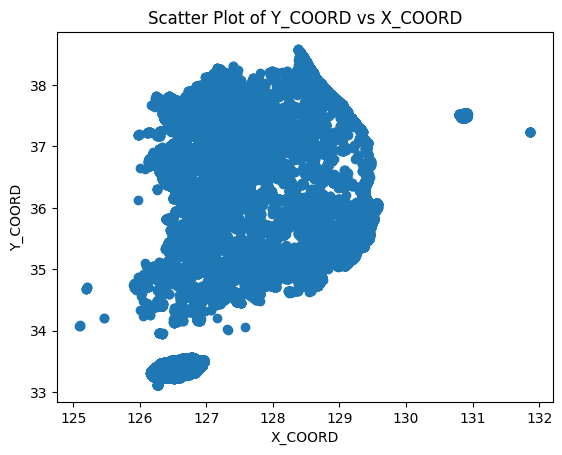

In [8]:
import matplotlib.pyplot as plt

visit_area_info['X_COORD'] = visit_area_info['X_COORD'].astype(str).str.extract(r'(\d+\.\d{1,4})').astype(float)
visit_area_info['Y_COORD'] = visit_area_info['Y_COORD'].astype(str).str.extract(r'(\d+\.\d{1,4})').astype(float)


visit_area_info['X_COORD'] = visit_area_info['X_COORD'].astype(np.float64)
visit_area_info['Y_COORD'] = visit_area_info['Y_COORD'].astype(np.float64)

condition2 = (visit_area_info['X_COORD'] <= 40)
visit_area_info = visit_area_info.drop(visit_area_info[condition2].index)
visit_area_info = visit_area_info.reset_index(drop = True)


print(len(visit_area_info[visit_area_info['X_COORD'].isna()]))
print(len(visit_area_info[visit_area_info['Y_COORD'].isna()]))


plt.scatter(visit_area_info['X_COORD'], visit_area_info['Y_COORD'])

plt.title('Scatter Plot of Y_COORD vs X_COORD')
plt.xlabel('X_COORD')
plt.ylabel('Y_COORD')

plt.show()

### 경도 33.6 이상인 방문지 삭제

In [9]:
condition3 = (visit_area_info['Y_COORD'] >= 33.6)
visit_area_info = visit_area_info.drop(visit_area_info[condition3].index)
visit_area_info = visit_area_info.reset_index(drop = True)

print(visit_area_info.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82572 entries, 0 to 82571
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   VISIT_AREA_ID        82572 non-null  int64  
 1   TRAVEL_ID            82572 non-null  object 
 2   VISIT_ORDER          82572 non-null  int64  
 3   VISIT_AREA_NM        82572 non-null  object 
 4   VISIT_START_YMD      82572 non-null  object 
 5   VISIT_END_YMD        82572 non-null  object 
 6   ROAD_NM_ADDR         44852 non-null  object 
 7   LOTNO_ADDR           47920 non-null  object 
 8   X_COORD              49301 non-null  float64
 9   Y_COORD              49301 non-null  float64
 10  ROAD_NM_CD           62 non-null     float64
 11  LOTNO_CD             8786 non-null   object 
 12  POI_ID               30624 non-null  object 
 13  POI_NM               30624 non-null  object 
 14  RESIDENCE_TIME_MIN   69345 non-null  float64
 15  VISIT_AREA_TYPE_CD   82572 non-null 

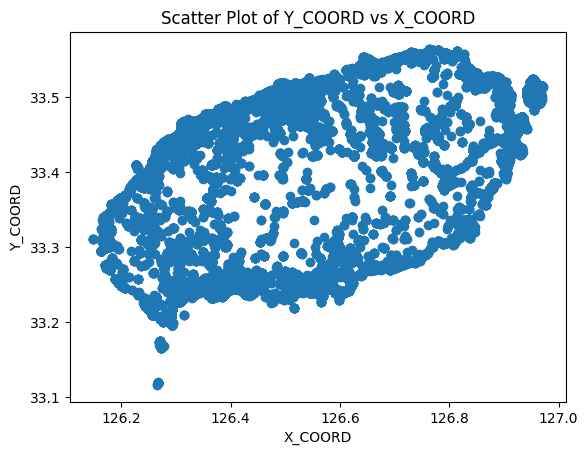

In [10]:
import matplotlib.pyplot as plt

plt.scatter(visit_area_info['X_COORD'], visit_area_info['Y_COORD'])

plt.title('Scatter Plot of Y_COORD vs X_COORD')
plt.xlabel('X_COORD')
plt.ylabel('Y_COORD')

plt.show()

### 경도, 위도, 주소명 결측치 확인 및 삭제

In [11]:
print(len(visit_area_info))
print(len(visit_area_info[visit_area_info['X_COORD'].isna() & visit_area_info['ROAD_NM_ADDR'].isna() & visit_area_info['LOTNO_ADDR'].isna()]))
print(len(visit_area_info[visit_area_info['Y_COORD'].isna()]))
print(len(visit_area_info[visit_area_info['X_COORD'].isna()]))

82572
29417
33271
33271


In [12]:
visit_area_info = visit_area_info.drop(visit_area_info[visit_area_info['ROAD_NM_ADDR'].isna() & visit_area_info['LOTNO_ADDR'].isna()].index)

In [13]:
print(len(visit_area_info))
print(len(visit_area_info[visit_area_info['ROAD_NM_ADDR'].isna() & visit_area_info['LOTNO_ADDR'].isna()]))

52106
0


### 제주도 내의 시 (제주시, 서귀포시) 새로운 열으로 만듦

In [14]:
# 'ROAD_NM_ADDR' 열의 값이 '제주'로 시작하는 행만 남김
jeju_road_nm_condition = visit_area_info['ROAD_NM_ADDR'].fillna('').str.startswith('제주')
visit_area_info = visit_area_info[jeju_road_nm_condition]

# 'LOTNO_ADDR' 열의 값이 '제주'로 시작하는 행만 남김
jeju_lotno_condition = visit_area_info['LOTNO_ADDR'].fillna('').str.startswith('제주')
visit_area_info = visit_area_info[jeju_lotno_condition]

In [15]:
import pandas as pd

visit_area_info['SI'] = ''

visit_area_info.loc[visit_area_info['LOTNO_ADDR'].str.contains('서귀포', na=False), 'SI'] = '서귀포'
visit_area_info.loc[visit_area_info['SI'] == '', 'SI'] = '제주'

print(visit_area_info[['LOTNO_ADDR', 'SI']])

                        LOTNO_ADDR   SI
691          제주특별자치도 제주시 노형동 904-4   제주
816          제주특별자치도 제주시 용담2동 2002   제주
1092         제주특별자치도 제주시 용담2동 2002   제주
1639       제주특별자치도 제주시 용담삼동 1020-1   제주
1778         제주특별자치도 제주시 용담2동 2002   제주
...                            ...  ...
82566       제주특별자치도 서귀포시 서귀동 277-2  서귀포
82567     제주특별자치도 제주시 한림읍 협재리 1398   제주
82568        제주특별자치도 제주시 용담이동 2002   제주
82569  제주특별자치도 서귀포시 남원읍 남원리 2384-1  서귀포
82570   제주특별자치도 서귀포시 성산읍 삼달리 437-5  서귀포

[40392 rows x 2 columns]


### 방문지정보 저장

In [16]:
visit_area_info.to_csv('tn_visit_area_info_방문지정보_제주.csv', index=False, encoding='utf-8-sig')

## 여행객정보 전처리

In [17]:
TRAVEL_ID_LST = visit_area_info['TRAVEL_ID'].unique()
TRAVEL_ID_LST_modified = [travel_id[2:] for travel_id in TRAVEL_ID_LST]
len(TRAVEL_ID_LST_modified)

3073

In [18]:
TRAVEL_ID_LST_modified

['a004118',
 'a006552',
 'a001090',
 'a000110',
 'a000503',
 'a015175',
 'a000134',
 'a009440',
 'a014333',
 'a000287',
 'a011368',
 'a002878',
 'a001960',
 'a000100',
 'a015837',
 'a001982',
 'd004639',
 'd012476',
 'a010430',
 'd004784',
 'a018143',
 'a003234',
 'a007004',
 'a011200',
 'b009490',
 'b010961',
 'b004075',
 'b014710',
 'b000465',
 'c009086',
 'c003286',
 'c001399',
 'c006719',
 'd006731',
 'd002613',
 'd001386',
 'd002308',
 'd000654',
 'd009541',
 'd004269',
 'd007013',
 'd006824',
 'd002306',
 'd003453',
 'd001278',
 'b001930',
 'd003736',
 'd000475',
 'd004101',
 'd000014',
 'd000787',
 'd000881',
 'd009147',
 'd006400',
 'd002118',
 'd005792',
 'd010177',
 'd009662',
 'd011528',
 'd009241',
 'd006290',
 'd002182',
 'd003694',
 'd002734',
 'd009186',
 'd009681',
 'd006839',
 'd002138',
 'd000902',
 'd006998',
 'd001836',
 'd012344',
 'd001935',
 'd002000',
 'd003990',
 'd005392',
 'd002667',
 'd007188',
 'd003119',
 'd004191',
 'd002464',
 'd001877',
 'd000159',
 'd0

In [19]:
traveller_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14400 entries, 0 to 14399
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   TRAVELER_ID                14400 non-null  object 
 1   RESIDENCE_SGG_CD           14400 non-null  int64  
 2   GENDER                     14400 non-null  object 
 3   AGE_GRP                    14400 non-null  int64  
 4   EDU_NM                     14400 non-null  int64  
 5   EDU_FNSH_SE                14399 non-null  float64
 6   MARR_STTS                  14398 non-null  float64
 7   FAMILY_MEMB                14400 non-null  int64  
 8   JOB_NM                     13753 non-null  float64
 9   JOB_ETC                    647 non-null    float64
 10  INCOME                     14400 non-null  int64  
 11  HOUSE_INCOME               10716 non-null  float64
 12  TRAVEL_TERM                14400 non-null  int64  
 13  TRAVEL_NUM                 14400 non-null  int

In [20]:
invalid_traveler_condition = traveller_master['TRAVELER_ID'].astype(str).isin(TRAVEL_ID_LST_modified)
traveller_master_1 = traveller_master[invalid_traveler_condition]
traveller_master_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2772 entries, 9 to 14399
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   TRAVELER_ID                2772 non-null   object 
 1   RESIDENCE_SGG_CD           2772 non-null   int64  
 2   GENDER                     2772 non-null   object 
 3   AGE_GRP                    2772 non-null   int64  
 4   EDU_NM                     2772 non-null   int64  
 5   EDU_FNSH_SE                2772 non-null   float64
 6   MARR_STTS                  2772 non-null   float64
 7   FAMILY_MEMB                2772 non-null   int64  
 8   JOB_NM                     2688 non-null   float64
 9   JOB_ETC                    84 non-null     float64
 10  INCOME                     2772 non-null   int64  
 11  HOUSE_INCOME               1975 non-null   float64
 12  TRAVEL_TERM                2772 non-null   int64  
 13  TRAVEL_NUM                 2772 non-null   int64  
 

In [21]:
missing_traveler_ids = set(TRAVEL_ID_LST_modified) - set(traveller_master_1['TRAVELER_ID'].astype(str))
print(missing_traveler_ids)

{'d001435', 'd012331', 'd001523', 'd004333', 'd011694', 'd012290', 'd009728', 'd007764', 'd007783', 'd002398', 'd002565', 'd003974', 'd000593', 'd000117', 'd001597', 'd003364', 'd012325', 'd008036', 'd002091', 'd002345', 'd008122', 'd004191', 'd010070', 'd001363', 'a007125', 'd006991', 'd001430', 'd001755', 'd000473', 'd002844', 'd000948', 'd010844', 'd000872', 'd010628', 'd000162', 'd000749', 'd000796', 'd000891', 'd005909', 'd001917', 'd007369', 'd003024', 'd004077', 'd001941', 'd002120', 'd001380', 'd001967', 'd009451', 'd004953', 'd002770', 'd001872', 'd000251', 'd003665', 'd000018', 'd000482', 'd009519', 'd000408', 'd001701', 'd003623', 'd008023', 'd004359', 'd001031', 'd004697', 'd001849', 'd009361', 'd010450', 'd000347', 'd004324', 'd002431', 'd000648', 'd003897', 'd007597', 'd001439', 'd012317', 'd003580', 'd004911', 'b000786', 'd012443', 'd010212', 'd006944', 'd001984', 'd001270', 'd010680', 'd012336', 'd001451', 'd008013', 'd009612', 'd006874', 'd001999', 'd005328', 'd003200'

### 여행객정보 저장

In [22]:
traveller_master_1.to_csv('tn_traveller_master_여행객 Master_제주.csv', index=False, encoding='utf-8-sig')

## 여행정보 전처리

In [23]:
invalid_travel_id_condition = travel['TRAVEL_ID'].astype(str).isin(TRAVEL_ID_LST)
travel_1 = travel[invalid_travel_id_condition]
travel_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2763 entries, 159 to 14399
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   TRAVEL_ID             2763 non-null   object
 1   TRAVEL_NM             2763 non-null   object
 2   TRAVELER_ID           2763 non-null   object
 3   TRAVEL_PURPOSE        2763 non-null   object
 4   TRAVEL_START_YMD      2763 non-null   object
 5   TRAVEL_END_YMD        2763 non-null   object
 6   MVMN_NM               2656 non-null   object
 7   TRAVEL_PERSONA        799 non-null    object
 8   TRAVEL_MISSION        2763 non-null   object
 9   TRAVEL_MISSION_CHECK  2763 non-null   object
dtypes: object(10)
memory usage: 237.4+ KB


In [24]:
invalid_travel_id_condition = travel['TRAVELER_ID'].astype(str).isin(TRAVEL_ID_LST_modified)
travel_2 = travel[invalid_travel_id_condition]
travel_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2763 entries, 159 to 14399
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   TRAVEL_ID             2763 non-null   object
 1   TRAVEL_NM             2763 non-null   object
 2   TRAVELER_ID           2763 non-null   object
 3   TRAVEL_PURPOSE        2763 non-null   object
 4   TRAVEL_START_YMD      2763 non-null   object
 5   TRAVEL_END_YMD        2763 non-null   object
 6   MVMN_NM               2656 non-null   object
 7   TRAVEL_PERSONA        799 non-null    object
 8   TRAVEL_MISSION        2763 non-null   object
 9   TRAVEL_MISSION_CHECK  2763 non-null   object
dtypes: object(10)
memory usage: 237.4+ KB


### 여행정보 저장

In [25]:
travel_2.to_csv('tn_travel_여행_제주.csv', index=False, encoding='utf-8-sig')

## 방문지정보, 여행객정보, 여행정보의 공통된'TRAVEL_ID'로 정리

In [26]:
merged_df = pd.merge(traveller_master_1, travel_2, on='TRAVELER_ID', how='inner')
number_of_common_travelers = len(merged_df)
print(number_of_common_travelers)


2493


In [27]:
final_traveler_id = merged_df['TRAVELER_ID'].unique()
final_travel_id = merged_df['TRAVEL_ID'].unique()

In [28]:
final_visit_area_info_condition = visit_area_info['TRAVEL_ID'].astype(str).isin(final_travel_id)
final_visit_area_info = visit_area_info[final_visit_area_info_condition]

In [29]:
final_visitor_master_condition = traveller_master_1['TRAVELER_ID'].astype(str).isin(final_traveler_id)
final_visitor_master_info = traveller_master_1[final_visitor_master_condition]

In [30]:
final_travel_condition = travel_2['TRAVELER_ID'].astype(str).isin(final_traveler_id)
final_travel = travel_2[final_travel_condition]

In [31]:
final_visit_area_info.to_csv('tn_visit_area_info_방문지정보_제주_final.csv', index=False, encoding='utf-8-sig')
final_visitor_master_info.to_csv('tn_traveller_master_여행객 Master_제주_final.csv', index=False, encoding='utf-8-sig')
final_travel.to_csv('tn_travel_여행_제주_final.csv', index=False, encoding='utf-8-sig')

In [32]:
len(visit_area_info['TRAVEL_ID'].unique())

3073

In [33]:
traveller_master_1

,TRAVELER_ID,RESIDENCE_SGG_CD,GENDER,AGE_GRP,EDU_NM,EDU_FNSH_SE,MARR_STTS,FAMILY_MEMB,JOB_NM,JOB_ETC,INCOME,HOUSE_INCOME,TRAVEL_TERM,TRAVEL_NUM,TRAVEL_LIKE_SIDO_1,TRAVEL_LIKE_SGG_1,TRAVEL_LIKE_SIDO_2,TRAVEL_LIKE_SGG_2,TRAVEL_LIKE_SIDO_3,TRAVEL_LIKE_SGG_3,TRAVEL_STYL_1,TRAVEL_STYL_2,TRAVEL_STYL_3,TRAVEL_STYL_4,TRAVEL_STYL_5,TRAVEL_STYL_6,TRAVEL_STYL_7,TRAVEL_STYL_8,TRAVEL_STATUS_RESIDENCE,TRAVEL_STATUS_DESTINATION,TRAVEL_STATUS_ACCOMPANY,TRAVEL_STATUS_YMD,TRAVEL_MOTIVE_1,TRAVEL_MOTIVE_2,TRAVEL_MOTIVE_3,TRAVEL_COMPANIONS_NUM
9,a004118,50,여,30,6,1.0,1.0,2,3.0,NaN,5,8.0,3,6,26,26350,11,11680,46,46130,4,3,1,4,6,4,7,4,제주특별자치도,인천,나홀로 여행,2022-10-01~2022-10-03,1.0,7.0,2.0,0
38,a015175,50,남,50,2,1.0,2.0,4,4.0,NaN,3,6.0,3,6,11,11350,42,42150,26,26710,4,5,6,5,4,5,4,6,제주특별자치도,서울,나홀로 여행,2022-10-29~2022-10-30,7.0,1.0,6.0,0
116,d012476,50,여,40,6,1.0,2.0,1,13.0,NaN,3,NaN,3,4,41,41280,50,50130,42,42110,4,4,4,4,4,4,4,4,제주특별자치도,제주,나홀로 여행,2022-11-09~2022-11-09,7.0,NaN,NaN,0
141,a000110,50,여,20,4,1.0,1.0,3,4.0,NaN,4,6.0,3,2,11,11440,26,26440,50,50130,4,3,3,1,2,5,2,5,제주특별자치도,서울,나홀로 여행,2022-08-27~2022-08-30,2.0,7.0,5.0,0
346,a014333,50,여,30,7,1.0,1.0,2,2.0,NaN,4,7.0,2,2,41,41110,26,26530,46,46150,4,2,6,1,4,6,1,5,제주특별자치도,경기,나홀로 여행,2022-10-29~2022-10-30,1.0,3.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14393,d000419,11,남,40,6,1.0,2.0,1,2.0,NaN,7,NaN,2,2,50,50130,41,41360,30,30140,6,4,4,3,5,3,4,6,서울특별시,제주,나홀로 여행,2022-08-23~2022-08-25,2.0,8.0,4.0,0
14396,d004823,50,남,40,6,1.0,1.0,1,2.0,NaN,5,NaN,2,1,50,50130,50,50110,42,42150,1,1,1,1,1,1,1,4,제주특별자치도,제주,나홀로 여행,2022-10-19~2022-10-21,4.0,2.0,1.0,0
14397,d006166,11,여,50,6,1.0,2.0,3,5.0,NaN,2,5.0,2,12,42,42150,26,26350,48,48840,2,2,3,4,2,2,6,4,서울특별시,제주,3대 동반 여행(친척 포함),2022-10-17~2022-10-20,2.0,6.0,7.0,2
14398,d011757,11,남,20,6,2.0,1.0,3,12.0,NaN,3,8.0,3,2,50,50110,42,42720,26,26350,6,1,1,2,6,2,3,6,서울특별시,제주,2인 여행(가족 외),2022-11-07~2022-11-09,3.0,2.0,1.0,1
